In [334]:
import requests
import os
import os.path
import sys
import importlib
import urllib
from lxml import etree
import pandas as pd
import copy
import io
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-whitegrid')

if os.path.isdir(os.path.join("../../..", "modules")):
    module_dir = os.path.join("../../..", "modules")
else:
    module_dir = os.path.join("../..", "modules")

module_path = os.path.abspath(module_dir)
if not module_path in sys.path:
    sys.path.append(module_path)

import util
importlib.reload(util)

<module 'util' from 'C:\\Users\\markr\\cs181\\cs181-f20\\modules\\util.py'>

In [2]:
nhl_creds = util.read_creds("sportradar", ".", "creds.json")
apikey = nhl_creds['apikey']

In [3]:
urlpred = "api.sportradar.us"

The following two functions are the first key to accessing all the necessary data for what we need to do. Both perform the same function, but with two separate implementations (more on that later). The reason this is necessary is because nearly every request is team specific, and a team is identified through the API's arbitrary team id which is only accessible through a league hierarchy request. The result of the two functions is a dictionary mapping a team's alias, the 2-3 character string used by the National Hockey League to identify teams, to the API's team id's.

In [105]:
resourcepath = "/nhl/trial/v7/en/league/hierarchy.json"
def getTeamIDs(my_api_key):
    """
    Returns a python dictionary mapping team alias to team id's
    Parameters:
        my_api_key: api key used to access the api
    """
    url = util.buildURL(resourcepath, urlpred)
    paramsD = {'api_key':my_api_key}
    response = requests.get(url, params = paramsD)
    if response.status_code != 200:
        return None

    jsonResp = response.json()
    teamIDs = {}
    conferences = jsonResp['conferences']
    for conference in conferences:
        divisions = conference['divisions']
        for division in divisions:
            teams = division['teams']
            for team in teams:
                teamIDs[team['alias']] = team['id']
                
    teamIDPD = pd.DataFrame.from_dict(teamIDs, orient='index', columns=['id'])
    return teamIDPD
    
teamIDs = getTeamIDs(apikey)

In [106]:
def getTeamIDsXML():
    """
    Returns a python dictionary mapping team alias to team id's
    Parameters:
        None
    """
    tree = etree.parse('hierarchy.xml')
    root = tree.getroot()
    
    #generating parallel lists of team alias' and team id's
    aliasXP = "//team/@alias"
    aliasList = root.xpath(aliasXP)
    idXP = "//team/@id"
    idList = root.xpath(idXP)
    
    teamIDDict = {}
    for count in range(len(aliasList)):
        teamIDDict[aliasList[count]] = idList[count]
        
    teamIDs = pd.DataFrame.from_dict(teamIDDict, orient='index', columns=['id'])
    return teamIDs

teamIDs = getTeamIDsXML()

The reason the above function accesses the data through a local XML file as opposed to fetching it from the API is because in the XML files provided by the API, they include namspace data which affects etree's ability to properly parse the data. Because this file was a standalone (I.e. no adjacent files like there are for the different teams), I accessed the file through my web browser, downloaded it, and removed the single xmlns attribute. Thus, the file hierarchy.xml is exactly the same as what would've been gotten from a get request only without the namespace attribute. Naturally, the two functions yield the same dataframe despite the difference in implementation.

In [116]:
assert(getTeamIDs(apikey).equals(getTeamIDsXML()))
#teamIDs.at['OTT', 'id']

This next function getTeamStats provides us with both team statistics for a given season, and the statistics of all players who played for said team in the given season. This will allow us to compare players against the team's mean analytics to guage performance relative to their teammates. Also, this provides us with player ID's which act much in the same way as the team ID's we fetched above.

In [198]:
def getTeamStats(my_api_key, teamID, year, scope="REG"):
    """
    Fetches and returns a dictionary containing all team stats(includes player stats) based on the parameters.
    Parameters:
        my_api_key: api key used to access the api
        teamID: ID of the team we're fetching player stats from
        year: Starting year of nhl season we're fetching from
        scope: REG for regular season stats, PST for postseason
    """
    template = "/nhl/trial/v7/en/seasons/{}/{}/teams/{}/analytics.json"
    resourcepath = template.format(year,scope,teamID)
    
    url = util.buildURL(resourcepath, urlpred)
    paramsD = {'api_key':my_api_key}
    response = requests.get(url, params = paramsD)
    if response.status_code != 200:
        return None
    jsonResp = response.json()
    return jsonResp
    
teamstats = getTeamStats(apikey, TeamIDs['VGK'], 2018)

The function getAllTeamStats simply runs the above function on every team, placing all the data into a dictionary which maps team alias to the return value of getTeamStats on the specified team. The function takes a bit of a delay because the API limits to one get request per second.

In [154]:
import time

In [213]:
def getAllTeamStats(my_api_key, teamIDs, year, scope="REG"):
    """
    Using the response from getTeamStats, this function builds and returns multiple pandas dataframes representing the data.
    Parameters:
        my_api_key: api key used to access the api
        teamIDs: Pandas dataframe holding team IDs
        year: Starting year of nhl season we're fetching from
        scope: REG for regular season stats, PST for postseason
    """
    teams = {}
    aliasList = list(teamIDs.index.values)
    for alias in aliasList:
        teamID = teamIDs.at[alias, 'id']
        teamStats = getTeamStats(my_api_key, teamID, year, scope=scope)
        teams[alias] = teamStats
        time.sleep(3) #Allow time for 1 get/second limit to pass because otherwise it was losing files
    return teams

In [226]:
teams = getAllTeamStats(apikey, teamIDs, 2018)

The function generateTeamsDF creates a pandas dataframe which holds all team statistics from the previously specified season. This does not include the player statistics of the team, that will be implemented in another function. This dataframe will allow us to measure the relationship between certain team stats and how heavily they influence overall records.

In [322]:
def generateTeamsDF(teams):
    """
    Builds and returns a pandas dataframe that holds all team average statistics provided from the getTeamStats method.
    Parameters:
        teams: dictionary of dictionaries containing team statistics
    """
    leagueData = []
    include = ['id', 'name', 'market']
    for alias in teams:
        #Name of team and API id
        businessData = {key: teams[alias][key] for key in include}
        businessData['name'] = businessData['market'] + ' ' + businessData['name']
        businessData.pop('market')
        businessData['alias'] = alias
        
        #Team averages of player stats
        avgStats = teams[alias]['own_record']['statistics']['average']
        shotData = avgStats['shots']
        avgStats.pop('shots')
        avgStats = {**avgStats, **shotData}
        
        #Combining business data and average stats
        completeTeamData = {**businessData, **avgStats}
        leagueData.append(completeTeamData)
        
    leagueDataDF = pd.DataFrame(leagueData)
    return leagueDataDF

In [323]:
teams2 = copy.deepcopy(teams)
leagueData = generateTeamsDF(teams2)

In [324]:
leagueData.head()

,id,name,alias,corsi_for,corsi_against,fenwick_for,fenwick_against,on_ice_shots_for,on_ice_shots_against,average_shot_distance,...,slap_shot_shots,slap_shot_goals,backhand_shot_shots,backhand_shot_goals,tip_shot_shots,tip_shot_goals,snap_shot_shots,snap_shot_goals,wrap_around_shot_shots,wrap_around_shot_goals
0,42376e1c-6da8-461e-9443-cfcf0a9fcc4d,Vegas Golden Knights,VGK,53.96,44.74,39.49,33.05,28.62,24.43,36.878,...,3.87,0.23,2.96,0.37,1.18,0.20,4.38,0.38,0.66,0.01
1,44151f7a-0f24-11e2-8525-18a905767e44,Los Angeles Kings,LA,46.48,49.83,34.49,37.52,24.21,26.30,39.098,...,5.15,0.38,2.40,0.20,1.51,0.21,4.10,0.41,0.13,0.02
2,44153da1-0f24-11e2-8525-18a905767e44,Arizona Coyotes,ARI,47.90,50.32,35.40,36.62,25.30,25.88,38.750,...,3.83,0.21,2.70,0.34,1.27,0.12,2.38,0.20,0.35,0.04
3,44155909-0f24-11e2-8525-18a905767e44,San Jose Sharks,SJ,52.70,44.09,38.57,32.60,27.22,23.26,36.918,...,4.79,0.34,2.40,0.32,1.90,0.29,3.43,0.44,0.43,0.05
4,44159241-0f24-11e2-8525-18a905767e44,Calgary Flames,CGY,50.63,43.51,37.34,32.90,26.59,23.27,35.673,...,4.00,0.21,2.60,0.41,1.91,0.43,3.45,0.34,0.24,0.01


This next function will perform nearly the same task as the one above, only this time it will be fetching and compiling player statistics into one large dataframe

In [325]:
def generatePlayersDF(teams):
    """
    Builds and returns a pandas dataframe that holds stats of all players who played in a given season.
    Parameters:
        teams: dictionary of dictionaries containing team statistics
    """
    players = []
    personal = ['id', 'full_name', 'position']
    performance = ['corsi_pct', 'fenwick_pct', 'on_ice_shots_pct']
    
    #Looping through each team
    for alias in teams:
        teamID = teams[alias]['id']
        teamPlayers = teams[alias]['players']
        
        #Looping through each player who played a game for a specified team
        for player in teamPlayers:
            personalData = {key: player[key] for key in personal}
            personalData['team_id'] = teamID
            
            #Num of shots/goals with each shot-type
            shotData = player['statistics']['average']['shots']
            
            #Offensive/defensive zone start percentage
            startData = player['statistics']['average']['starts']
            performanceData = {key: player['statistics']['total'][key] for key in performance}
            playerData = {**personalData, **performanceData, **shotData, **startData}
            players.append(playerData)
    playersDF = pd.DataFrame(players)
    playersDF = playersDF.set_index(['id', 'team_id'])
    return playersDF

In [326]:
teams2 = copy.deepcopy(teams)
playerData = generatePlayersDF(teams2)

In [327]:
playerData.head()

,,full_name,position,corsi_pct,fenwick_pct,on_ice_shots_pct,wrist_shot_shots,wrist_shot_goals,slap_shot_shots,slap_shot_goals,backhand_shot_shots,backhand_shot_goals,tip_shot_shots,tip_shot_goals,snap_shot_shots,snap_shot_goals,wrap_around_shot_shots,wrap_around_shot_goals,offensive_zone_starts,defensive_zone_starts,neutral_zone_starts
id,team_id,,,,,,,,,,,,,,,,,,,,
222b1a87-b947-4188-bfe9-70ee0c257203,42376e1c-6da8-461e-9443-cfcf0a9fcc4d,Pierre-Edouard Bellemare,F,0.536,0.533,0.543,0.87,0.07,0.05,0.00,0.18,0.00,0.07,0.00,0.14,0.00,0.04,0.00,3.70,4.92,3.53
f9158f7d-2d91-47ad-8298-1d4d1eaeaef6,42376e1c-6da8-461e-9443-cfcf0a9fcc4d,Nick Holden,D,0.556,0.553,0.540,0.69,0.03,0.36,0.02,0.05,0.00,0.02,0.00,0.15,0.00,0.02,0.00,5.95,5.18,5.80
1e2dfac4-9f24-4d83-a6f0-ba1a75dd97dc,42376e1c-6da8-461e-9443-cfcf0a9fcc4d,Erik Haula,F,0.618,0.602,0.601,1.00,0.13,0.07,0.00,0.00,0.00,0.07,0.07,0.53,0.00,0.07,0.00,8.00,4.27,3.60
4369c1c6-0f24-11e2-8525-18a905767e44,42376e1c-6da8-461e-9443-cfcf0a9fcc4d,Cody Eakin,F,0.499,0.493,0.483,0.96,0.18,0.17,0.03,0.10,0.04,0.09,0.01,0.15,0.01,0.04,0.01,5.22,5.38,4.40
4343c158-0f24-11e2-8525-18a905767e44,42376e1c-6da8-461e-9443-cfcf0a9fcc4d,Marc-Andre Fleury,G,0.539,0.539,0.540,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.95,18.80,18.16


This next function does not make use of the API, but instead will utilize web-scraping to fetch league standings for the given year, as well as a few other statistics that were not included in what we acquired from getTeamStats

In [328]:
def scrapeStandings(year, leagueData):
    """
    Scrapes an HTML website to fetch NHL standings from a given year. Returns a pandas dataframe representation of the data.
    Parameters:
        year: *ending* year of the season we're fetching from 
    """
    
    #Requesting data from hockeydb
    location = "www.hockeydb.com"
    template = "/ihdb/stats/leagues/seasons/nhl1927{}.html"
    resource = template.format(year)
    url = util.buildURL(resource, location)
    r = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}) #User-Agent header lets us get pass bot check
    assert r.status_code == 200
    
    #Parsing the HTML file
    teamStandings = []
    htmlparser = etree.HTMLParser()
    root = etree.fromstring(r.content, parser=htmlparser)
    tree = etree.parse(io.BytesIO(r.content), parser=htmlparser)
    table = root.xpath("//tbody/tr[not(@class != 'hid*')]")
    
    #Assigning HTML text to its designated variable
    for tr in table:
        teamStanding = {}
        teamStanding['name'] = tr.xpath("td[position() = 1]/a/text()")[0]
        teamStanding['points'] = tr.xpath("td[position() = 7]/text()")[0]
        teamStanding['goals_for'] = tr.xpath("td[position() = 8]/text()")[0]
        teamStanding['goals_against'] = tr.xpath("td[position() = 9]/text()")[0]
        teamStandings.append(teamStanding)
    teamStandingsDF = pd.DataFrame(teamStandings)
    return teamStandingsDF
    
standings = scrapeStandings(2019, leagueData)

With this function, we're finally able to measure relationships between the team-average analytics that we acquired from the API and the overall performance of the team. The index of this dataframe is the API's team id which will map to every other variable.

In [331]:
def combineTeamsAndStandings(teams, standings):
    """
    Merges two previously created dataframes such that we can compare a teams average statistics with overall
    performance through points, goals for, and goals against.
    Parameters:
        teams: Dataframe with team average data
        standings: Dataframe with team overall standings
    """
    complete = teams.merge(standings, on='name')
    return complete.set_index('id')

teamsComplete = combineTeamsAndStandings(leagueData, standings)

In [333]:
teamsComplete.head()

,name,alias,corsi_for,corsi_against,fenwick_for,fenwick_against,on_ice_shots_for,on_ice_shots_against,average_shot_distance,wrist_shot_shots,...,backhand_shot_goals,tip_shot_shots,tip_shot_goals,snap_shot_shots,snap_shot_goals,wrap_around_shot_shots,wrap_around_shot_goals,points,goals_for,goals_against
id,,,,,,,,,,,,,,,,,,,,,
42376e1c-6da8-461e-9443-cfcf0a9fcc4d,Vegas Golden Knights,VGK,53.96,44.74,39.49,33.05,28.62,24.43,36.878,20.23,...,0.37,1.18,0.20,4.38,0.38,0.66,0.01,93,249,230
44151f7a-0f24-11e2-8525-18a905767e44,Los Angeles Kings,LA,46.48,49.83,34.49,37.52,24.21,26.30,39.098,15.24,...,0.20,1.51,0.21,4.10,0.41,0.13,0.02,71,202,263
44153da1-0f24-11e2-8525-18a905767e44,Arizona Coyotes,ARI,47.90,50.32,35.40,36.62,25.30,25.88,38.750,20.13,...,0.34,1.27,0.12,2.38,0.20,0.35,0.04,86,213,223
44155909-0f24-11e2-8525-18a905767e44,San Jose Sharks,SJ,52.70,44.09,38.57,32.60,27.22,23.26,36.918,18.84,...,0.32,1.90,0.29,3.43,0.44,0.43,0.05,101,289,261
44159241-0f24-11e2-8525-18a905767e44,Calgary Flames,CGY,50.63,43.51,37.34,32.90,26.59,23.27,35.673,19.87,...,0.41,1.91,0.43,3.45,0.34,0.24,0.01,107,289,227


Plotting relationship between team average corsi_for with points

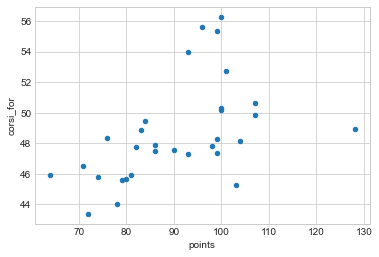

In [344]:
teamsComplete.points = teamsComplete.points.astype(float)
teamsComplete.plot.scatter('points', 'corsi_for')

Plotting a relationship between average_shot_distance against goals for and against.

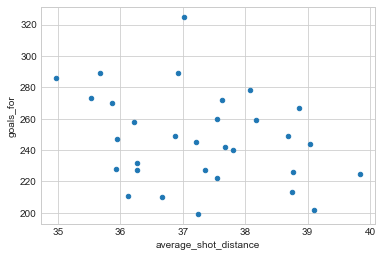

In [346]:
teamsComplete.average_shot_distance = teamsComplete.average_shot_distance.astype(float)
teamsComplete.goals_for = teamsComplete.goals_for.astype(float)
teamsComplete.goals_against = teamsComplete.goals_against.astype(float)
teamsComplete.plot.scatter('average_shot_distance', 'goals_for')

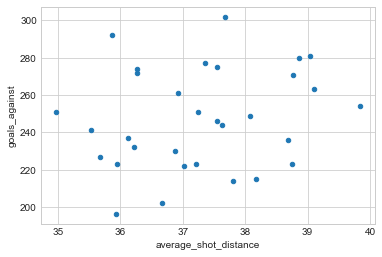

In [347]:
teamsComplete.plot.scatter('average_shot_distance', 'goals_against')

This function allows us to separate players by position to see how the average playstyle differs among positions.

In [348]:
def separatePositions(players):
    """
    Returns three pandas dataframes, one for forwards, one for defensemen, and another for goalies in that order.
    Parameters:
        players: Parent dataset which contains data for all three positions
    """
    
    forwards = players[players.position == 'F']
    defensemen = players[players.position == 'D']
    goalies = players[players.position == 'G']
    return forwards, defensemen, goalies

forwards, defensemen, goalies = separatePositions(playerData)

Below, this function allows us to measure the distribution of goals scored by the shot-type used. This will allow us to measure the difference in the effectiveness of each shot-type for the different positions and how they differ.

In [384]:
def getGoalDistribution(players, name):
    """
    Creates and returns a pandas dataframe with one row, showing the proportion of goals scored for each
    shot type by the players provided.
    Parameters:
        players: Dataframe of player data that we're using to calculate shot-type goal distribution
        name: name of row
    """
    #Calculating average number of goals scored with each shot type on a aingle-game average
    goalAvg = players.agg({'wrist_shot_goals' : ['mean'], 'slap_shot_goals' : ['mean'], 
                               'backhand_shot_goals' : ['mean'], 'tip_shot_goals' : ['mean'],
                               'snap_shot_goals' : ['mean'], 'wrap_around_shot_goals' : ['mean']})
    #Average goals per game overall
    goalAvgTotal = goalAvg.sum(axis = 1).at['mean']
    #Dividing each shot-types avg goal/game by overall avg goal/game to get the proportion of goals scored
    #Using that shot-type
    goalDistribution = goalAvg.div(goalAvgTotal)
    return goalDistribution.rename(columns={'wrist_shot_goals':'Wrist shot', 'slap_shot_goals':'Slap shot',
                                            'backhand_shot_goals':'Backhand shot', 'tip_shot_goals':'Tip shot',
                                            'snap_shot_goals':'Snap shot', 'wrap_around_shot_goals':'Wrap around'},
                                   index={'mean': name})
    

For the purpose of creating a multiple bar plot, below we're concatenating dataframes of forward goal distribution and defensemen goal distribution.

In [388]:
forwardGoalDist = getGoalDistribution(forwards, 'Forwards')
defenseGoalDist = getGoalDistribution(defensemen, 'Defensemen')
goalDist = pd.concat([forwardGoalDist, defenseGoalDist])

#Transposing so we have the shot type as the x axis for the bar plot
goalDist = goalDist.transpose()

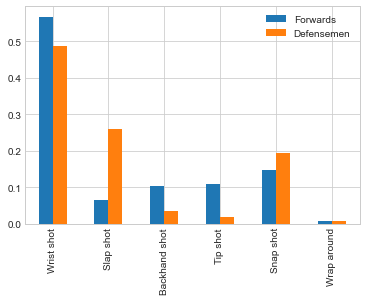

In [390]:
goalDist.plot.bar()

In [397]:
def getShotDistribution(players, name):
    """
    Creates and returns a pandas dataframe with one row, showing the proportion of shots taken for each
    shot type by the players provided.
    Parameters:
        players: Dataframe of player data that we're using to calculate shot-type shots distribution
        name: name of row
    """
    #Calculating average number of goals scored with each shot type on a aingle-game average
    shotAvg = players.agg({'wrist_shot_shots' : ['mean'], 'slap_shot_shots' : ['mean'], 
                               'backhand_shot_shots' : ['mean'], 'tip_shot_shots' : ['mean'],
                               'snap_shot_shots' : ['mean'], 'wrap_around_shot_shots' : ['mean']})
    #Average goals per game overall
    shotAvgTotal = shotAvg.sum(axis = 1).at['mean']
    #Dividing each shot-types avg goal/game by overall avg goal/game to get the proportion of goals scored
    #Using that shot-type
    shotDistribution = shotAvg.div(shotAvgTotal)
    return shotDistribution.rename(columns={'wrist_shot_shots':'Wrist shot', 'slap_shot_shots':'Slap shot',
                                            'backhand_shot_shots':'Backhand shot', 'tip_shot_shots':'Tip shot',
                                            'snap_shot_shots':'Snap shot', 'wrap_around_shot_shots':'Wrap around'},
                                   index={'mean': name})

In [422]:
forwardShotDist = getShotDistribution(forwards, 'shotsF')
defenseShotDist = getShotDistribution(defensemen, 'shotsD')

forwardShotPerf = pd.concat([forwardShotDist, forwardGoalDist])
defenseShotPerf = pd.concat([defenseShotDist, defenseGoalDist])

fShotPerf = (forwardShotPerf.loc['Forwards'] / forwardShotPerf.loc['shotsF']).to_frame()
dShotPerf = (defenseShotPerf.loc['Defensemen'] / defenseShotPerf.loc['shotsD']).to_frame()

fShotPerf = fShotPerf.transpose().rename(index={0:"Forwards"})
dShotPerf = dShotPerf.transpose().rename(index={0:"Defensemen"})

shotPerf = pd.concat([fShotPerf, dShotPerf])
shotPerf = shotPerf.transpose()

The entire above block is attempting to measure how well a shot type is performing relative to the amount of goals being scored using it and the amount of shots being taken using it. A higher value means it's performing better and possibly more use would be beneficial.

In [423]:
shotPerf

,Forwards,Defensemen
Wrist shot,0.953212,0.946181
Slap shot,0.888975,0.846545
Backhand shot,1.027054,1.276842
Tip shot,1.555342,2.869206
Snap shot,1.007145,1.354161
Wrap around,0.538012,2.635010


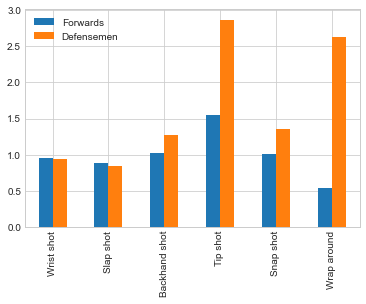

In [424]:
shotPerf.plot.bar()

In [426]:
#Shifting back to proper form
goalDist = goalDist.transpose()
shotPerf = shotPerf.transpose()

Exporting dataframes to CSV's

In [428]:
teamsComplete.to_csv('team-data.csv', index = True, header=True)
playerData.to_csv('player-data.csv', index = True, header=True)
teamIDs.to_csv('teamIDs.csv', index = True, header=True)
goalDist.to_csv('goal-distribution.csv', index = True, header=True)
shotPerf.to_csv('shot-performance.csv', index = True, header=True)